In [2]:
###General Code First Box
import pandas as pd
import numpy as np
import scanpy as sc
import magpy as mp
import scipy.stats as stats
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

def sort_list_by_pctexp(adata, gene_list, groupby='lineage'):
    subset = adata[:,gene_list]
    clusters = subset.obs[groupby].unique()
    pctexp = np.zeros((len(clusters),subset.shape[1]))
    for i,cluster in enumerate(clusters):
        subset2 = subset[subset.obs[groupby]==cluster]
        pctexp[i] = (subset2.layers['raw_normalized']>0).sum(axis=0).A1 / subset.shape[0]
    subset.var['pctmax'] = pctexp.max(axis=0)
    sorted_list = subset.var['pctmax'].sort_values(ascending=False).index.tolist()
    return sorted_list
def sort_list_by_mean(adata, gene_list, groupby='lineage'):
    subset = adata[:,gene_list]
    clusters = subset.obs[groupby].unique()
    cmeans = np.zeros((len(clusters),subset.shape[1]))
    for i,cluster in enumerate(clusters):
        subset2 = subset[subset.obs[groupby]==cluster]
        cmeans[i] = subset2.layers['raw_normalized'].mean(axis=0).A1
    subset.var['cmeans'] = cmeans.max(axis=0)
    sorted_list = subset.var['cmeans'].sort_values(ascending=False).index.tolist()
    return sorted_list
def means_to_df(adata, gene_list, save=None, groupby='lineage'):
    subset = adata[:,gene_list]
    clusters = subset.obs[groupby].unique()
    cmeans = {}
    for i,cluster in enumerate(clusters):
        subset2 = subset[subset.obs[groupby]==cluster]
        cmeans[cluster] = subset2.layers['raw_normalized'].mean(axis=0).A1
    df = pd.DataFrame(cmeans,index=gene_list)
    if save: df.to_csv(save)
    return df

combined_path = "/proj/magness/CDS010-014-015_combined"

# sc.set_figure_params(dpi_save = 300, format = 'svg')
fig_path = combined_path+'/drug-receptors'
sc.settings.figdir = fig_path

Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.5.h5ad

The following genes were filtered out:
[]

The following genes were filtered out:
['NR3C1', 'IMPDH1', 'ITGA4', 'JAK3']



Trying to set attribute `.var` of view, copying.


High-Expression >0.5
['FKBP1A', 'IMPDH2', 'JAK1', 'DHFR', 'JAK2']


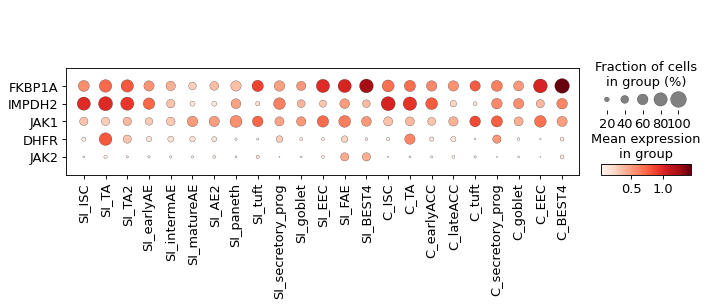

The following genes were filtered out:
['FKBP1A', 'IMPDH2', 'JAK1', 'DHFR', 'JAK2', 'JAK3']



Trying to set attribute `.var` of view, copying.


Mid-Expression 0.05-0.5
['NR3C1', 'IMPDH1', 'ITGA4']


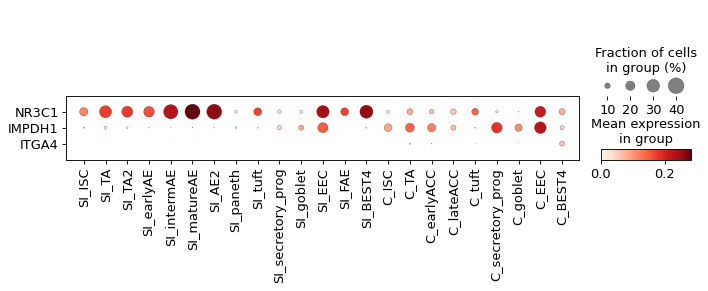

The following genes were filtered out:
['FKBP1A', 'IMPDH2', 'JAK1', 'DHFR', 'JAK2', 'NR3C1', 'IMPDH1', 'ITGA4']



Trying to set attribute `.var` of view, copying.


Low-Expression <0.05
['JAK3']


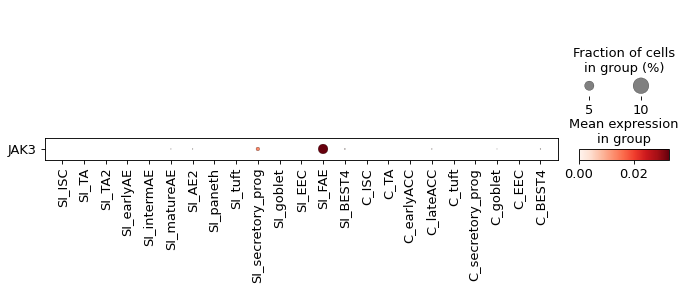

In [4]:
###Figure 16C
### Primary Gene Targets of IBD Drugs by Expression Level

adata = mp.load(combined_path, "clustered_annotated_adata_k25_lr0.92_v1.5.h5ad")
adata.obs.lineage = adata.obs.lineage.cat.reorder_categories(['SI_ISC','SI_TA','SI_TA2','SI_earlyAE','SI_intermAE','SI_matureAE','SI_AE2','SI_paneth', 'SI_tuft','SI_secretory_prog','SI_goblet','SI_EEC','SI_FAE', 'SI_BEST4','C_ISC','C_TA', 'C_earlyACC','C_lateACC', 'C_tuft','C_secretory_prog','C_goblet','C_EEC','C_BEST4'])

means = np.zeros((adata.shape[1],len(adata.obs.lineage.unique())))
for i,lineage in enumerate(adata.obs.lineage.unique()):
    subset = adata[adata.obs.lineage==lineage]
    means[:,i] = subset.layers['raw_normalized'].mean(axis=0)

genes = [
'FKBP1A','IMPDH2','JAK1','DHFR','JAK2','NR3C1','IMPDH1','ITGA4','JAK3']
genes_list = mp.filter_genes(adata, genes)
    
###High expression = Subset to genes with at least a mean of 0.5 in one cluster
subset_high = adata[:,(means > 0.5).any(axis=1)]
gene_list = mp.filter_genes(subset_high, genes)
gene_list = sort_list_by_mean(subset_high, gene_list, groupby='lineage')
print('High-Expression >0.5')
print(gene_list)
sc.pl.dotplot(subset_high, var_names=gene_list, groupby = 'lineage', swap_axes=True,)

###Mid Expression = expression between 0.05 and 0.5 
subset_mid = adata[:,((means > 0.05).any(axis=1))&((means <= 0.5).all(axis=1))]
gene_list = mp.filter_genes(subset_mid, genes)
gene_list = sort_list_by_mean(subset_mid, gene_list, groupby='lineage')
print('Mid-Expression 0.05-0.5')
print(gene_list)
sc.pl.dotplot(subset_mid, var_names=gene_list, groupby = 'lineage', swap_axes=True,)


###Low expression = Subset to genes with <0.05 in all clusters
subset_high = adata[:,(means < 0.05).all(axis=1)]
gene_list = mp.filter_genes(subset_high, genes)
gene_list = sort_list_by_mean(subset_high, gene_list, groupby='lineage')
print('Low-Expression <0.05')
print(gene_list)
sc.pl.dotplot(subset_high, var_names=gene_list, groupby = 'lineage', swap_axes=True)


Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.5.h5ad

Donor 1


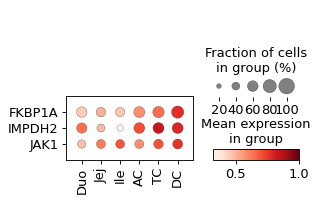

Donor 2


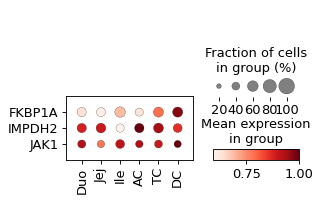

Donor 3


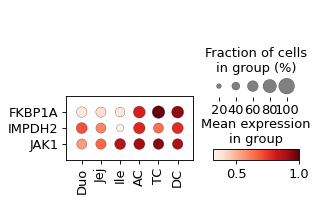

In [3]:
###Figure 16E
###Drug target genes by donor and region 

adata = mp.load(combined_path, "clustered_annotated_adata_k25_lr0.92_v1.5.h5ad")
def scale_donor_region(adata):
    donors = adata.obs.donor.unique()
    regions = adata.obs.region.unique()
    
    cmeans = np.zeros((adata.shape[1],len(donors),len(regions)))
    for i,donor in enumerate(donors):
        for j,region in enumerate(regions):
            subset = adata[((adata.obs.donor==donor) & (adata.obs.region==region))]
            cmeans[:,i,j] = subset.layers['raw_normalized'].mean(axis=0)
            
    scale_factors = cmeans.max(axis=(1,2))
    adata.layers['raw_scaled'] = adata.layers['raw_normalized'] / scale_factors[None,:]
    
    return adata


adata = scale_donor_region(adata)


for donor in ['Donor 1','Donor 2','Donor 3']:
    print(donor)
    subset = adata[adata.obs.donor==donor]
    sc.pl.dotplot(subset,['FKBP1A','IMPDH2','JAK1'],groupby='region',layer='raw_scaled',swap_axes=True, vmax=1,dot_max=1)#,save = f'{donor}_IBDtargets.svg')
